In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

In [39]:
from datetime import datetime
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import utils
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Activation, Input, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
import scipy as sc
import time

In [195]:
datos = pd.read_csv('M:/Users/angui/Desktop/proyectos_personales/Proyectos_Personales/train.csv')

In [196]:
datos

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [197]:
def limpieza_datos(datos):
    l = []
    l2 = []
    l3 = []
    for i in range(len(datos['Name'])):
        l.append(datos['SibSp'][i] + datos['Parch'][i]+1)
        l2.append(datos['Name'][i].split(',')[1].split('.')[0].replace(" ", ""))
        l3.append(datos['Ticket'][i][0])
    datos['Family_Size'] = l
    datos['Title'] = l2
    datos['Tick'] = l3

    datos['Title'] = datos['Title'].replace('Mlle', 'Miss')
    datos['Title'] = datos['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
    datos.Title.loc[ (datos.Title !=  'Master') & (datos.Title !=  'Dr') &(datos.Title !=  'Mr') & (datos.Title !=  'Miss') 
             & (datos.Title !=  'Mrs')] = 'Others'
    
    print('hola') 
    guess_Fare = np.nanmedian(datos.Fare.loc[(datos.Pclass == 3) & (datos.Embarked == 'S')])
    print(guess_Fare)
    datos.Fare.fillna(guess_Fare , inplace=True)

    datos.Embarked = datos.Embarked.fillna('S')
    try:
        datos.Survived = datos.Survived.astype('float')
    except:
        'este es el test'
    mediana = datos[datos.Age.notna()].Age.median()
    datos.Age = datos.Age.fillna(mediana)
    
    datos['Sex'] = datos['Sex'].astype('category')
    datos['Sex'] = datos['Sex'].cat.codes

    varcontinuas = ['Title', 'Embarked']
    for var in varcontinuas:
        datos = pd.concat([datos, 
                    pd.get_dummies(datos[var], prefix=var)], axis=1)
        del datos[var]
    
    continuas = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']
    scaler = StandardScaler()

    for var in continuas:
        datos[var] = datos[var].astype('float64')
        datos[var] = scaler.fit_transform(datos[var].values.reshape(-1, 1))
        
    
    return datos

In [198]:
datos = limpieza_datos(datos)
datos = datos.drop(datos.columns[[0, 3, 8, 10, 12]],axis = 1)

hola
8.05


M:\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [199]:
#X_train = datos.drop(columns = ['Survived'])
X_train = datos.drop(columns = ['Survived'])
y_train = datos['Survived']

In [200]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Family_Size,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,1,-0.565736,0.432793,-0.473674,-0.502445,0.059160,0,0,0,1,0,0,0,0,1
1,-1.566107,0,0.663861,0.432793,-0.473674,0.786845,0.059160,0,0,0,0,1,0,1,0,0
2,0.827377,0,-0.258337,-0.474545,-0.473674,-0.488854,-0.560975,0,0,1,0,0,0,0,0,1
3,-1.566107,0,0.433312,0.432793,-0.473674,0.420730,0.059160,0,0,0,0,1,0,0,0,1
4,0.827377,1,0.433312,-0.474545,-0.473674,-0.486337,-0.560975,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,1,-0.181487,-0.474545,-0.473674,-0.386671,-0.560975,0,0,0,0,0,1,0,0,1
887,-1.566107,0,-0.796286,-0.474545,-0.473674,-0.044381,-0.560975,0,0,1,0,0,0,0,0,1
888,0.827377,0,-0.104637,0.432793,2.008933,-0.176263,1.299429,0,0,1,0,0,0,0,0,1
889,-1.566107,1,-0.258337,-0.474545,-0.473674,-0.044381,-0.560975,0,0,0,1,0,0,1,0,0


In [87]:
dfaux = pd.DataFrame(columns = ['Epocas','Capa1 - Funcion de activacion', 'Capa2 - Funcion de activacion', 'Capa3 - Funcion de activacion', 'learning_rate', 'batch_size'])

In [89]:
def modelo(epocas, act_capa1, act_capa2, act_capa3, learning_rate, batch_size):
    dfaux = pd.DataFrame(columns = ['Epocas','Capa1 - Funcion de activacion', 'Capa2 - Funcion de activacion', 'Capa3 - Funcion de activacion', 'learning_rate', 'batch_size', 'precision', 'perdida'])
    i = 0
    for epoca in epocas:
        for act1 in act_capa1:
            for act2 in act_capa2:
                for act3 in act_capa3:
                    for lrate in learning_rate:
                        for bz in batch_size:
                            model = Sequential()
                            model.add(Dense(10, input_dim = X_train.shape[1], activation = act1))
                            model.add(Dense(15,activation = act2))
                            model.add(Dense(1, activation = act3))
                            model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr = lrate), metrics = ['binary_accuracy'])
                            history = model.fit(X_train, y_train, epochs=epoca, batch_size=bz, validation_split=0.2, verbose=0)
                            precision = max(history.history.get('binary_accuracy'))
                            perdida = max(history.history.get('loss'))
                            dfaux.loc[i] = (epoca, act1, act2, act3, lrate, bz, precision, perdida)
                            i = i+1
        
    return dfaux

In [90]:
epocas = [50, 100]
act_capa1 = ['relu', 'sigmoid']
act_capa2 = ['softmax', 'relu', 'sigmoid']
act_capa3 = ['sigmoid', 'relu']
learning_rate = [0.005]
batch_size = [32, 64]
DataFrame = modelo(epocas, act_capa1, act_capa2, act_capa3, learning_rate, batch_size)

In [247]:
DataFrame.sort_values(by = ['precision', 'perdida'], ascending = [False, True])

,Epocas,Capa1 - Funcion de activacion,Capa2 - Funcion de activacion,Capa3 - Funcion de activacion,learning_rate,batch_size,precision,perdida
31,100,relu,relu,relu,0.005,64,0.814607,1.823452
30,100,relu,relu,relu,0.005,32,0.807584,1.607975
4,50,relu,relu,sigmoid,0.005,32,0.806180,0.665910
34,100,relu,sigmoid,relu,0.005,32,0.806180,0.865478
7,50,relu,relu,relu,0.005,64,0.806180,2.420105
18,50,sigmoid,relu,relu,0.005,32,0.792135,0.632694
40,100,sigmoid,relu,sigmoid,0.005,32,0.790730,0.655304
19,50,sigmoid,relu,relu,0.005,64,0.789326,0.736364
42,100,sigmoid,relu,relu,0.005,32,0.789326,0.923665
10,50,relu,sigmoid,relu,0.005,32,0.786517,0.685319


In [53]:
max(history.history.get('loss')))
print(max(history.history.get('binary_accuracy')))

0.6781937479972839
0.800561785697937


In [201]:
model = Sequential()
model.add(Dense(10, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(15,activation = 'relu'))
model.add(Dense(1, activation = 'relu'))
model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr = 0.005), metrics = ['binary_accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

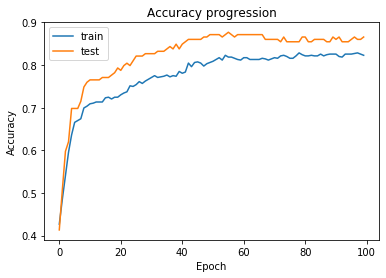

In [202]:
import matplotlib.pyplot as plt
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Accuracy progression")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="best")
plt.show()

In [203]:
datos2 =  pd.read_csv('M:/Users/angui/Desktop/proyectos_personales/Proyectos_Personales/test.csv')

In [204]:
datos2 = limpieza_datos(datos2)

hola
8.05


M:\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [205]:
datos3 = datos2.drop(columns = ['PassengerId', 'Name', 'Cabin', 'Tick', 'Ticket'])

In [206]:
datos3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Family_Size,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Embarked_C,Embarked_Q,Embarked_S
0,0.873482,1,0.386231,-0.499470,-0.400248,-0.497079,-0.553443,0,0,0,1,0,0,0,1,0
1,0.873482,0,1.371370,0.616992,-0.400248,-0.511942,0.105643,0,0,0,0,1,0,0,0,1
2,-0.315819,1,2.553537,-0.499470,-0.400248,-0.463770,-0.553443,0,0,0,1,0,0,0,1,0
3,0.873482,1,-0.204852,-0.499470,-0.400248,-0.482143,-0.553443,0,0,0,1,0,0,0,0,1
4,0.873482,0,-0.598908,0.616992,0.619896,-0.417167,0.764728,0,0,0,0,1,0,0,0,1


In [207]:
datos.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family_Size,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.827377,1,-0.565736,0.432793,-0.473674,-0.502445,0.059160,0,0,0,1,0,0,0,0,1
1,1.0,-1.566107,0,0.663861,0.432793,-0.473674,0.786845,0.059160,0,0,0,0,1,0,1,0,0
2,1.0,0.827377,0,-0.258337,-0.474545,-0.473674,-0.488854,-0.560975,0,0,1,0,0,0,0,0,1
3,1.0,-1.566107,0,0.433312,0.432793,-0.473674,0.420730,0.059160,0,0,0,0,1,0,0,0,1
4,0.0,0.827377,1,0.433312,-0.474545,-0.473674,-0.486337,-0.560975,0,0,0,1,0,0,0,0,1


In [240]:
datos3.loc[152]

Pclass          0.873482
Sex             1.000000
Age             2.435320
SibSp          -0.499470
Parch          -0.400248
Fare           -0.493121
Family_Size    -0.553443
Title_Dr        0.000000
Title_Master    0.000000
Title_Miss      0.000000
Title_Mr        1.000000
Title_Mrs       0.000000
Title_Others    0.000000
Embarked_C      0.000000
Embarked_Q      0.000000
Embarked_S      1.000000
Name: 152, dtype: float64

In [241]:
output = model.predict(datos3)
l = []
for i in range(len(output)):
    l.append(int(np.round(output[i][0])))

In [242]:
df3 = pd.DataFrame()
df3['PassengerId'] = datos2['PassengerId']
df3['Survived'] = l

In [243]:
df3.loc[343].Survived = 1

In [244]:
datos2.loc[343]

PassengerId                                                  1235
Pclass                                                   -1.50512
Name            Cardeza, Mrs. James Warburton Martinez (Charlo...
Sex                                                             0
Age                                                       2.23829
SibSp                                                    -0.49947
Parch                                                    0.619896
Ticket                                                   PC 17755
Fare                                                      8.54577
Cabin                                                 B51 B53 B55
Family_Size                                              0.105643
Tick                                                            P
Title_Dr                                                        0
Title_Master                                                    0
Title_Miss                                                      0
Title_Mr  

In [246]:
df3.to_csv(r'M:/Users/angui/Desktop/proyectos_personales/Proyectos_Personales/predictions.csv', index = False)